In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [2]:
syscov = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### Visualization of the covariance matrix:

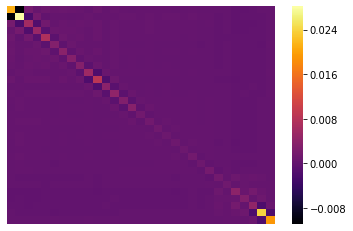

In [3]:
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')
plt.savefig("original_cov_binned_JLA.png", dpi=200)

### Generate a data set with covariance matrix from the original plus gaussian noise

In [4]:
numMatrix = 1000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.normal(size=syscov.shape) 
    covset[i] = syscov + 0.001 * err
    covset_noise[i] = syscov + 0.05 * err

 Generating 905 matrix 

 Generating 1000 matrix 

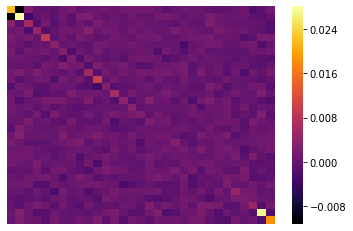

In [5]:
sns.heatmap(pd.DataFrame(covset[1]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

In [6]:
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]

# Split data in training set and test sets
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

# Reshape arrays
covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))

In [7]:
original_dim = 31 * 31
intermediate_dim = 200
latent_dim = 31

inputs = tf.keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='tanh')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + tf.keras.backend.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

# Create encoder
encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='tanh')(latent_inputs)
outputs = layers.Dense(original_dim, activation='linear')(x)

decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_mlp')



In [8]:
reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_sigma)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 961)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 31), (None,  204862      input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 961)          199561      encoder[0][2]                    
__________________________________________________________________________________________________
tf_op_layer_Minimum (TensorFlow [(None, 961)]        0           decoder[0][0]                    
____________________________________________________________________________________________

In [9]:
autoencoder_train = vae.fit(covset_noise_train, covset_train,
                epochs=100,
#                 batch_size=,
#                 shuffle=True,
                validation_data=(covset_noise_test, covset_test))

Epoch 1/100
25/25 [==============================] - 0s 16ms/step - loss: 17.1114 - val_loss: 14.9803
Epoch 2/100
25/25 [==============================] - 0s 6ms/step - loss: 12.5407 - val_loss: 14.2447
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 11.3780 - val_loss: 11.7447
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 10.2778 - val_loss: 12.3058
Epoch 5/100
25/25 [==============================] - 0s 6ms/step - loss: 9.7683 - val_loss: 11.7097
Epoch 6/100
25/25 [==============================] - 0s 7ms/step - loss: 9.8177 - val_loss: 12.8717
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 8.7610 - val_loss: 11.6410
Epoch 8/100
25/25 [==============================] - 0s 7ms/step - loss: 8.8599 - val_loss: 11.9049
Epoch 9/100
25/25 [==============================] - 0s 5ms/step - loss: 9.9429 - val_loss: 14.0613
Epoch 10/100
25/25 [==============================] - 0s 5ms/step - loss: 10.5091 - val_loss: 1

In [10]:
encoded_data = encoder.predict(covset_test)
decoded_data = decoder.predict(encoded_data)
print(np.shape(encoded_data))

(3, 200, 31)


In [11]:
# # This is the size of our encoded representations
# encoding_dim = 31  

# # This is our input image
# input_img = tf.keras.Input(shape=(31*31,))

# # begin encoder
# x = layers.Dense(100, activation='relu')(input_img)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(100, activation='relu')(x)
# x = layers.Dropout(0.2)(x)
# encoded = layers.Dense(encoding_dim, activation='relu')(x)
# x = layers.Dropout(0.2)(encoded)
# #begin decoder
# x = layers.Dense(100, activation='relu')(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(100, activation='relu')(x)
# x = layers.Dropout(0.2)(x)
# decoded = layers.Dense(31*31, activation='linear')(x)


# # This model maps an input to its reconstruction
# autoencoder = tf.keras.Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', loss='mean_squared_error')
# autoencoder.summary()

In [12]:
# encoder = tf.keras.Model(input_img, encoded)

# # This is our encoded (31-dimensional) input
# encoded_input = tf.keras.Input(shape=(encoding_dim,))

# decoder_layer1 = autoencoder.layers[-5]
# decoder_layer2 = autoencoder.layers[-4]
# decoder_layer3 = autoencoder.layers[-3]
# decoder_layer4 = autoencoder.layers[-2]
# decoder_layer5 = autoencoder.layers[-1]

# # create the decoder model
# decoder = Model(encoded_input, 
#                 decoder_layer5(decoder_layer4(
#                     decoder_layer3(decoder_layer2(
#                         decoder_layer1(encoded_input))))))

In [13]:
# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
#                                    min_delta=0.0,
#                                    patience=10, 
#                                    restore_best_weights=True)]

# autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
#                 epochs=100,
#                 batch_size=1,
#                 shuffle=True,
#                 validation_data=(covset_noise_test, covset_test),
#                 callbacks=callbacks, verbose=0)

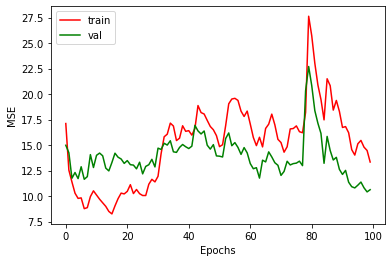

In [14]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_binned_JLA.png', dpi=50)

In [15]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2)

10.405378341674805


In [16]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)

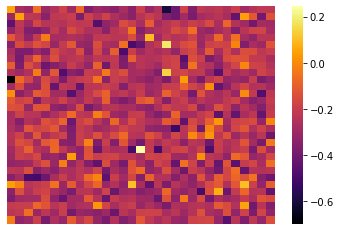

In [17]:
sns.heatmap(pd.DataFrame(decoded_imgs[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)


# this cov matrix work well within Bayesian inference
# np.savetxt("test.dat", decoded_imgs[0].reshape(31,31), delimiter= " ", header="#fake COV")


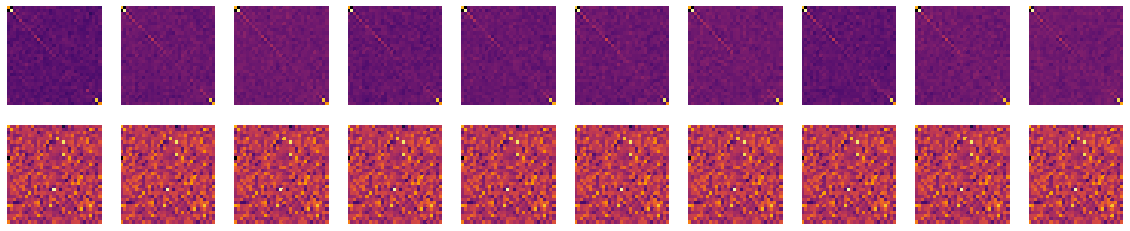

In [18]:
n = 10 
plt.figure(figsize=(20, 4))

for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    sns.heatmap(covset_test[i].reshape(31, 31), cbar=False, 
                fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[i].reshape(31, 31), cbar=False, 
                fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    
# plt.savefig('predicted_covs_binned_jla.png', dpi=200)

### Now we train another neural network for z and $D_L(z)$

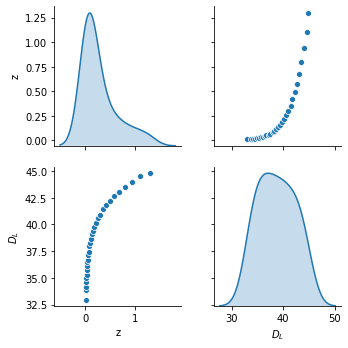

In [19]:
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
sns.pairplot(data, diag_kind="kde")
# plt.savefig("DistbinnedJLA.png")

In [20]:
shuffle = [x for x in range(len(data.values)) if x%2 == 0]
comp = [x for x in range(len(data.values)) if x%2 ==1]
shuffle.extend(comp)
data = data.values[shuffle]
z = data[:,0]
dl = data[:,1:]

In [21]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
# scalerz = StandardScaler()
# scalerz.fit(z.reshape(-1, 1))
# zz = scalerz.transform(z.reshape((-1,1)))
z_train, z_test = np.split(z, indx)
dl_train, dl_test = np.split(dl, indx)

In [22]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=20,
                                   restore_best_weights=True)]

In [23]:
def model(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = Dense(50, activation='relu')(efirst)
    x = Dense(50, activation='relu')(x)
    x = Dense(30, activation='relu')(x)
    elast = Dense(1, activation='linear')(x)
    return elast

input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 31        
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
____________________________________________________

In [24]:
model_train = neural_model.fit(z_train, dl_train, batch_size=1,
                                    epochs=500,verbose=1,
                                    validation_data=(z_test, dl_test))
#                                     callbacks=callbacks)

Epoch 1/500
24/24 [==============================] - 0s 7ms/step - loss: 1427.8427 - val_loss: 1691.6357
Epoch 2/500
24/24 [==============================] - 0s 2ms/step - loss: 1358.7620 - val_loss: 1507.9270
Epoch 3/500
24/24 [==============================] - 0s 2ms/step - loss: 1115.1776 - val_loss: 957.7380
Epoch 4/500
24/24 [==============================] - 0s 2ms/step - loss: 540.2072 - val_loss: 96.5303
Epoch 5/500
24/24 [==============================] - 0s 2ms/step - loss: 88.9182 - val_loss: 149.0741
Epoch 6/500
24/24 [==============================] - 0s 2ms/step - loss: 84.6835 - val_loss: 59.9125
Epoch 7/500
24/24 [==============================] - 0s 2ms/step - loss: 55.5565 - val_loss: 67.8536
Epoch 8/500
24/24 [==============================] - 0s 2ms/step - loss: 51.4125 - val_loss: 54.8306
Epoch 9/500
24/24 [==============================] - 0s 2ms/step - loss: 40.1493 - val_loss: 37.4386
Epoch 10/500
24/24 [==============================] - 0s 2ms/step - loss: 32.7

24/24 [==============================] - 0s 2ms/step - loss: 0.7946 - val_loss: 0.1969
Epoch 164/500
24/24 [==============================] - 0s 1ms/step - loss: 0.7445 - val_loss: 0.4606
Epoch 165/500
24/24 [==============================] - 0s 1ms/step - loss: 0.8624 - val_loss: 0.2516
Epoch 166/500
24/24 [==============================] - 0s 2ms/step - loss: 0.6805 - val_loss: 0.7621
Epoch 167/500
24/24 [==============================] - 0s 1ms/step - loss: 0.9485 - val_loss: 0.2419
Epoch 168/500
24/24 [==============================] - 0s 1ms/step - loss: 0.8154 - val_loss: 0.3668
Epoch 169/500
24/24 [==============================] - 0s 1ms/step - loss: 0.8018 - val_loss: 0.9330
Epoch 170/500
24/24 [==============================] - 0s 1ms/step - loss: 1.1271 - val_loss: 1.7912
Epoch 171/500
24/24 [==============================] - 0s 2ms/step - loss: 1.1004 - val_loss: 0.0513
Epoch 172/500
24/24 [==============================] - 0s 1ms/step - loss: 0.6334 - val_loss: 0.3243
Epoc

24/24 [==============================] - 0s 1ms/step - loss: 0.5186 - val_loss: 0.0822
Epoch 326/500
24/24 [==============================] - 0s 1ms/step - loss: 0.5400 - val_loss: 2.2000
Epoch 327/500
24/24 [==============================] - 0s 1ms/step - loss: 1.2977 - val_loss: 3.1925
Epoch 328/500
24/24 [==============================] - 0s 1ms/step - loss: 0.6870 - val_loss: 0.2387
Epoch 329/500
24/24 [==============================] - 0s 1ms/step - loss: 0.5027 - val_loss: 0.8266
Epoch 330/500
24/24 [==============================] - 0s 1ms/step - loss: 0.4326 - val_loss: 0.1809
Epoch 331/500
24/24 [==============================] - 0s 1ms/step - loss: 0.5056 - val_loss: 0.6165
Epoch 332/500
24/24 [==============================] - 0s 1ms/step - loss: 0.7233 - val_loss: 0.4306
Epoch 333/500
24/24 [==============================] - 0s 2ms/step - loss: 0.5724 - val_loss: 0.3475
Epoch 334/500
24/24 [==============================] - 0s 1ms/step - loss: 0.5561 - val_loss: 0.0524
Epoc

24/24 [==============================] - 0s 1ms/step - loss: 0.2426 - val_loss: 0.0147
Epoch 488/500
24/24 [==============================] - 0s 1ms/step - loss: 0.2713 - val_loss: 0.5145
Epoch 489/500
24/24 [==============================] - 0s 1ms/step - loss: 0.3018 - val_loss: 0.6380
Epoch 490/500
24/24 [==============================] - 0s 1ms/step - loss: 0.3705 - val_loss: 0.0687
Epoch 491/500
24/24 [==============================] - 0s 1ms/step - loss: 0.5879 - val_loss: 1.5212
Epoch 492/500
24/24 [==============================] - 0s 1ms/step - loss: 1.2875 - val_loss: 2.9454
Epoch 493/500
24/24 [==============================] - 0s 1ms/step - loss: 3.7309 - val_loss: 11.8328
Epoch 494/500
24/24 [==============================] - 0s 2ms/step - loss: 2.1096 - val_loss: 2.3428
Epoch 495/500
24/24 [==============================] - 0s 2ms/step - loss: 2.1505 - val_loss: 1.6250
Epoch 496/500
24/24 [==============================] - 0s 2ms/step - loss: 0.6460 - val_loss: 0.0830
Epo

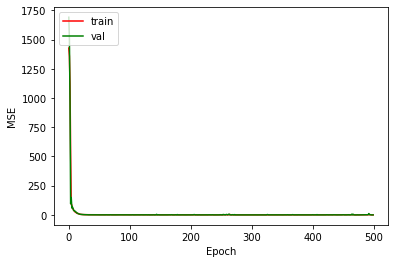

In [25]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_dlbinnedJla.png", dpi=200)

In [26]:
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet

0.11539851234019882

In [27]:
# ranz = np.random.uniform(np.min(z), np.max(z), size=31)
ranz = np.linspace(np.min(z), np.max(z), 31)
# ranzz = scalerz.transform(ranz.reshape((-1,1)))
pred_random = neural_model.predict(ranz)
np.shape(pred_random), np.shape(z)

((31, 1), (31,))

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$



In [28]:
fake_encoded = np.zeros(31)
avg_encoded = np.mean(encoded_imgs[2], axis=0)
print('fake encoded', np.shape(fake_encoded))
print('encoded imgs', np.shape(encoded_imgs))
print('avg encoded', np.shape(avg_encoded))
print('randz', np.shape(ranz))

for i, avg in enumerate(avg_encoded):
    alpha = avg/z[i]
    fake_encoded[i] = alpha * ranz[i]

fake encoded (31,)
encoded imgs (3, 200, 31)
avg encoded (31,)
randz (31,)


In [29]:
len(fake_encoded)

31

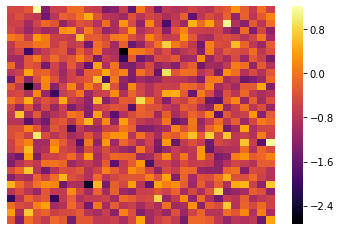

In [30]:
decoded_fake = decoder.predict(fake_encoded.reshape(1,31))

sns.heatmap(pd.DataFrame(decoded_fake[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno',
            robust=False)

# clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
# plt.savefig('fake_cov_jla.png', dpi=200)
# np.min(np.abs(decoded_fake[0, :]))

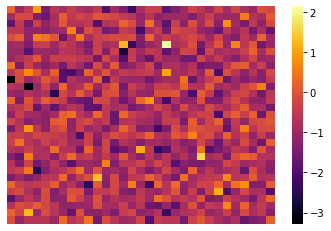

In [31]:
# clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
clean_img = vae.predict(decoded_fake[0, :].reshape(1,-1))
# clean_img = vae.predict(clean_img[0, :].reshape(1,-1))
sns.heatmap(pd.DataFrame(clean_img[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.savefig('fake_cov_clean_jla.png', dpi=200)

In [32]:
np.savetxt("fake_binned_JLA_COVdecoded.dat", decoded_fake[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
np.savetxt("fake_binned_JLA_COVdecodedclean.dat", clean_img[0, :].reshape(31,31), delimiter= " ", header="#fake COV")

In [33]:
count = 0
new_cov =decoded_fake[0, :].reshape(31,31)

for i in range(len(new_cov)):
    for j in range(len(new_cov)):
        if np.iscomplex(new_cov[i,j]):
            print("COMPLEX")
        if new_cov[i,j] != new_cov[j,i]:
            count+=1
            new_cov[j,i] = new_cov[i, j]

count

465

In [34]:
np.savetxt("fake_binned_JLA_COVdecodedsim.dat", new_cov, delimiter= " ", 
           header="#fake COV")

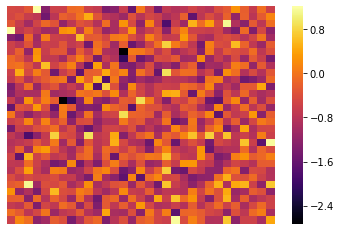

In [35]:
sns.heatmap(pd.DataFrame(new_cov), fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [36]:
fake_data = np.concatenate((ranz.reshape(-1,1), pred_random), axis=1)
np.savetxt("fake_binned_JLA.dat",  fake_data, delimiter= " ", 
           header="#fake data\n# z\n# mu")
errors = np.sqrt(np.abs(np.diagonal(syscov)))
fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))


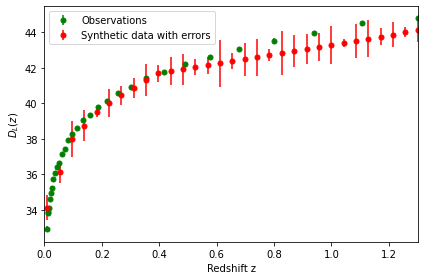

In [37]:
plt.errorbar(z, dl, yerr=errors, fmt='g.', markersize=10, label='Observations')
plt.errorbar(ranz, pred_random, 
             yerr=fakeerrors, fmt='r.', markersize=10., label='Synthetic data with errors')

plt.xlabel("Redshift z")
plt.ylabel("$D_L(z)$")
plt.xlim(0, np.max(z))
plt.tight_layout()
plt.legend()
plt.savefig('fake_vs_binned_jla.png', dpi=50)

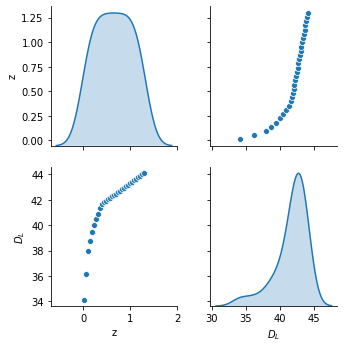

In [38]:
fake_datadf = pd.DataFrame(fake_data, columns=['z', '$D_L$'])
sns.pairplot(fake_datadf, diag_kind="kde")
plt.savefig('fake_binned_jla.png')

### NOW we use dropout as uncertainty estimator

In [39]:
from astroNN.nn.layers import MCDropout

In [40]:
# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img2 = tf.keras.Input(shape=(31*31,))

# begin encoder
x2 = layers.Dense(100, activation='tanh')(input_img2)
x2 = MCDropout(0.2)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.2)(x2)
encoded2 = layers.Dense(encoding_dim, activation='tanh')(x2)
x2 = MCDropout(0.2)(encoded2)

#begin decoder
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.2)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)

# x2 = MCDropout(0.2)(x2)
decoded2 = layers.Dense(31*31, activation='linear')(x2)


# This model maps an input to its reconstruction
autoencoder2 = tf.keras.Model(input_img2, decoded2)
autoencoder2.compile(optimizer='adam', loss='mean_squared_error')
autoencoder2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               96200     
_________________________________________________________________
MCDropout_1 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
MCDropout_2 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 31)                3131      
_________________________________________________________________
MCDropout_3 (MCDropout)      (None, 31)               

In [41]:
autoencoder2_train = autoencoder2.fit(covset_noise_train, covset_train,
                    epochs=500,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(covset_noise_test, covset_test),
                    callbacks=callbacks)

Epoch 1/500
25/25 [==============================] - 0s 7ms/step - loss: 6.9167e-04 - val_loss: 2.6863e-04
Epoch 2/500
25/25 [==============================] - 0s 3ms/step - loss: 1.4022e-04 - val_loss: 1.0655e-04
Epoch 3/500
25/25 [==============================] - 0s 6ms/step - loss: 6.8959e-05 - val_loss: 6.5325e-05
Epoch 4/500
25/25 [==============================] - 0s 3ms/step - loss: 4.4615e-05 - val_loss: 4.6642e-05
Epoch 5/500
25/25 [==============================] - 0s 3ms/step - loss: 3.3789e-05 - val_loss: 3.8746e-05
Epoch 6/500
25/25 [==============================] - 0s 3ms/step - loss: 2.6125e-05 - val_loss: 3.0642e-05
Epoch 7/500
25/25 [==============================] - 0s 3ms/step - loss: 2.0920e-05 - val_loss: 2.5437e-05
Epoch 8/500
25/25 [==============================] - 0s 3ms/step - loss: 1.7521e-05 - val_loss: 2.2693e-05
Epoch 9/500
25/25 [==============================] - 0s 3ms/step - loss: 1.4651e-05 - val_loss: 1.8938e-05
Epoch 10/500
25/25 [=================

Epoch 77/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2876e-06 - val_loss: 1.4517e-06
Epoch 78/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2779e-06 - val_loss: 1.4517e-06
Epoch 79/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2746e-06 - val_loss: 1.4445e-06
Epoch 80/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2702e-06 - val_loss: 1.4209e-06
Epoch 81/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2594e-06 - val_loss: 1.4180e-06
Epoch 82/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2594e-06 - val_loss: 1.3889e-06
Epoch 83/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2428e-06 - val_loss: 1.3874e-06
Epoch 84/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2396e-06 - val_loss: 1.3716e-06
Epoch 85/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2347e-06 - val_loss: 1.3567e-06
Epoch 86/500
25/25 [========

25/25 [==============================] - 0s 4ms/step - loss: 1.0629e-06 - val_loss: 1.0739e-06
Epoch 228/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0621e-06 - val_loss: 1.0712e-06
Epoch 229/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0621e-06 - val_loss: 1.0757e-06
Epoch 230/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0627e-06 - val_loss: 1.0733e-06
Epoch 231/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0627e-06 - val_loss: 1.0722e-06
Epoch 232/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0612e-06 - val_loss: 1.0734e-06
Epoch 233/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0642e-06 - val_loss: 1.0763e-06
Epoch 234/500
25/25 [==============================] - 0s 3ms/step - loss: 1.0631e-06 - val_loss: 1.0751e-06
Epoch 235/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0614e-06 - val_loss: 1.0737e-06
Epoch 236/500
25/25 [============

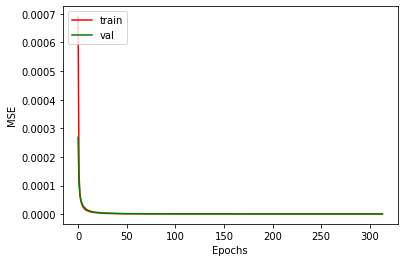

In [42]:
plt.plot(autoencoder2_train.history['loss'], color='r', )
plt.plot(autoencoder2_train.history['val_loss'], color='g')

plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_binned_JLAdropout.png', dpi=50)

In [43]:
encoder2 = tf.keras.Model(input_img2, encoded2)

# This is our encoded (32-dimensional) input
encoded2_input = tf.keras.Input(shape=(encoding_dim,))

decoder2_layer1 = autoencoder2.layers[-5]
decoder2_layer2 = autoencoder2.layers[-4]
decoder2_layer3 = autoencoder2.layers[-3]
decoder2_layer4 = autoencoder2.layers[-2]
decoder2_layer5 = autoencoder2.layers[-1]

# create the decoder model
decoder2 = Model(encoded2_input, 
                decoder2_layer5(decoder2_layer4(
                    decoder2_layer3(decoder2_layer2(
                        decoder2_layer1(encoded2_input))))))
decoder2.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
MCDropout_3 (MCDropout)      (None, 31)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               3200      
_________________________________________________________________
MCDropout_4 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_15 (Dense)             (None, 961)               97061     
Total params: 110,361
Trainable params: 110,361
Non-trainable params: 0
________________________________________________

In [44]:
# Generate test data
test_batch_size = 31*31
# x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0, 2., test_batch_size)
print(np.shape(fake_encoded))
mc_dropout_num = 100  # Run Dropout 100 times
predictions_dec = np.zeros((mc_dropout_num, 1, test_batch_size))
uncertainty = np.zeros((mc_dropout_num, 1, test_batch_size))
for i in range(mc_dropout_num):
    predictions_dec[i] = decoder2.predict(fake_encoded)
    
# get mean results and its varience
prediction_mc_dropout_dec = np.mean(predictions_dec, axis=0)
std_mc_dropout_dec = np.std(predictions_dec, axis=0)
np.shape(prediction_mc_dropout_dec), np.shape(std_mc_dropout_dec)

(31,)


ValueError: in user code:

    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer dense_13 is incompatible with the layer: expected axis -1 of input shape to have value 31 but received input with shape [None, 1]


In [ ]:
np.mean(std_mc_dropout_dec), np.shape(std_mc_dropout_dec)

In [ ]:
def model2_dropout(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = MCDropout(0.02)(efirst)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.02)(x)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.02)(x)
    x = Dense(30, activation='relu')(x)
    x = MCDropout(0.02)(x)
    elast = Dense(1, activation='linear')(x)
    return elast

input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2_dropout(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

In [ ]:
model2_train = neural_model2.fit(z_train, dl_train, batch_size=32,
                                    epochs=1000, verbose=0,
                                    validation_data=(z_test, dl_test))

In [ ]:
# Generate test data
test_batch_size = 31
x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0.01, np.max(z), test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 1))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = neural_model2.predict(scalerz.transform(x_test.reshape(-1,1)))
#     print(predictions[i])

# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [ ]:
plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.xlim(0)
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_dropoutJLA.png', dpi=100)

In [ ]:
Om = 0.27
w0 = -1

def RHSquared_a_lcdm(a):
    return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, model, w0, wa):
        if model == 'lcdm':
            return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
        elif model == 'owacdm':
            return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, model, w0, wa):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(model, w0, wa))
        r = r[0]    
        return r
    
def distance_modulus(z, model='lcdm', w0=-1, wa=0.5):
    return 5*np.log10(Da_z(z, model, w0, wa)*(1+z))+43

In [ ]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz))
#     fowacdm1.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.5))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

In [ ]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)

fakeerrors2 = np.sqrt(np.abs(np.diagonal(prediction_mc_dropout_dec .reshape(31,31))))

std_dropout_diag = np.sqrt(np.abs(np.diagonal(std_mc_dropout_dec.reshape(31,31))))

sigma = np.sqrt(std_mc_dropout.reshape(31,)**2 + fakeerrors2 + std_dropout_diag**2)

plt.errorbar(x_test, prediction_mc_dropout, yerr=sigma
             , markersize=10, fmt='.', 
             ecolor='blue', capthick=2, elinewidth=0.9, alpha=0.8, c='b',
             label='Synthetic data with $\sigma$')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(z, dl, errors, fmt='g.', markersize=10, label='Observations')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='r')
# plt.plot(zmodel, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
# plt.plot(zmodel, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(0, np.max(z)+0.05)
plt.xlabel('Redshift')
plt.ylabel('$D_L(z)$')
# plt.legend(loc='best')
plt.legend(loc='upper right')
# plt.show()
plt.savefig('DL_dropout5.png', dpi=50)

In [ ]:
np.savetxt("fake_binned_JLA_COVdecodedDO.dat", prediction_mc_dropout_dec[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
fake_data2 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)
np.savetxt("fake_binned_JLADO.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu")

sns.heatmap(pd.DataFrame(prediction_mc_dropout_dec[0, :].reshape(31,31)), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')
plt.savefig("fake_cov_binned_JLA_DO.png", dpi=200)

In [ ]:
fake_datadf2 = pd.DataFrame(fake_data2, columns=['z', '$D_L$'])
sns.pairplot(fake_datadf2, diag_kind="kde")
plt.savefig('fake_binned_jla22DO.png')

In [ ]:
# clean_img = autoencoder2.predict(prediction_mc_dropout_dec[0, :].reshape(1,-1))

In [ ]:
np.savetxt("fake_binned_JLA_COVdecodedDO.dat", clean_img.reshape(31,31), delimiter= " ", header="#fake COV")
fake_data2 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)
np.savetxt("fake_binned_JLADO.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu")